In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

import seaborn as sns

In [2]:
# 读取处理好的训练数据
## 数据的维度：5537, 299 = 3 + 34 + 1024 + 167
DATA = pd.read_csv("../DataPre/AChE-FeatureSelection.csv")
print("检测是否有NaN在数据集中: {}".format(True in DATA.isnull().any(axis=0).to_list()))
print("数据的维度为: {}".format(DATA.shape))
# 数据共有3234个非活性分子与2303个活性分子
print(DATA.loc[:,"IC50"].value_counts())

检测是否有NaN在数据集中: False
数据的维度为: (5537, 299)
1    3234
0    2303
Name: IC50, dtype: int64


In [3]:
DATA.head()

,Molecule ChEMBL ID,Smiles,IC50,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGLO,...,MACCS142,MACCS143,MACCS144,MACCS146,MACCS148,MACCS149,MACCS150,MACCS158,MACCS161,MACCS167
0,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,1,0.072572,-0.397902,0.397902,0.072572,14.735750,9.928703,-2.177276,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,CHEMBL4752675,CO[C@]1(c2cn(O)c(=O)c(C(=O)[C@@H]3[C@H](C)C=C[...,1,0.297000,-0.506511,0.506511,0.297000,16.637143,9.612362,-2.422533,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,CHEMBL571730,O=S(=O)(/N=C(\NCCCCNc1c2c(nc3ccccc13)CCCC2)N1C...,1,0.285110,-0.384221,0.384221,0.285110,35.496788,9.905624,-2.217193,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,CHEMBL3415559,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1,1,0.261042,-0.312676,0.312676,0.261042,16.179745,10.119205,-2.129961,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,CHEMBL3415564,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1F,1,0.261042,-0.312567,0.312567,0.261042,19.142192,10.119205,-2.130254,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [4]:
# 划分训练集与测试集,比例为0.2
x_train, x_test, y_train, y_test = train_test_split(DATA.iloc[:,3:], DATA["IC50"], test_size=0.2,
                 random_state=1)

x_train.to_csv("./train-x.csv",index=None)
x_test.to_csv("./test-x.csv",index=None)
y_train.to_csv("./train-y.csv",index=None)
y_test.to_csv("./test-y.csv",index=None)


In [7]:
from sklearn.decomposition import PCA
# 这里加一个PCA降维去说明测试集与训练集划分的充分性,这里降维的数据是分子描述符
data_for_pca = pd.concat([x_train,x_test],axis=0)

DFP = data_for_pca.iloc[:,:34]
DFP.head()


,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,...,SMR_VSA7,SlogP_VSA2,SlogP_VSA5,SlogP_VSA6,TPSA,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA8
1586,0.330660,-1.000000,1.000000,0.330660,79.905002,10.038619,-2.387852,2.292828,-2.997000,5.397268,...,147.877227,54.125909,80.320138,88.451846,130.28,66.433307,71.476253,69.410037,4.567100,38.112943
2712,0.059846,-0.393030,0.393030,0.059846,16.266235,10.093000,-2.268952,2.077406,-2.353745,4.889743,...,0.000000,35.744673,12.841643,0.000000,23.47,6.103966,0.000000,32.475912,0.000000,10.820344
1004,0.316600,-0.496758,0.496758,0.316600,16.465306,9.879833,-2.266687,2.250633,-2.434457,5.734741,...,29.326004,38.178007,17.547725,18.199101,41.57,12.072955,0.000000,25.011977,11.126903,17.449523
5221,0.416587,-0.493405,0.493405,0.416587,16.550333,10.062043,-2.171467,2.201289,-2.207819,5.858443,...,100.409798,31.192460,50.154748,88.074460,81.01,5.625586,35.921068,30.336075,37.313105,29.273170
4878,0.414454,-0.410216,0.414454,0.410216,16.553517,10.155997,-2.338118,2.147095,-2.473165,5.914462,...,71.800227,66.471603,18.050640,60.673324,53.09,12.000420,12.294268,38.287234,10.463361,29.165378


In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
myPCA = PCA(n_components=2,random_state=1,)
dfAfPCA = pd.DataFrame(myPCA.fit_transform(StandardScaler().fit_transform(DFP)),columns=["feature1","feature2"])
print(myPCA.explained_variance_ratio_)
print("{:.2f},{:.2f}".format(myPCA.explained_variance_ratio_[0],myPCA.explained_variance_ratio_[1]))

[0.25797198 0.17244897]
0.26,0.17


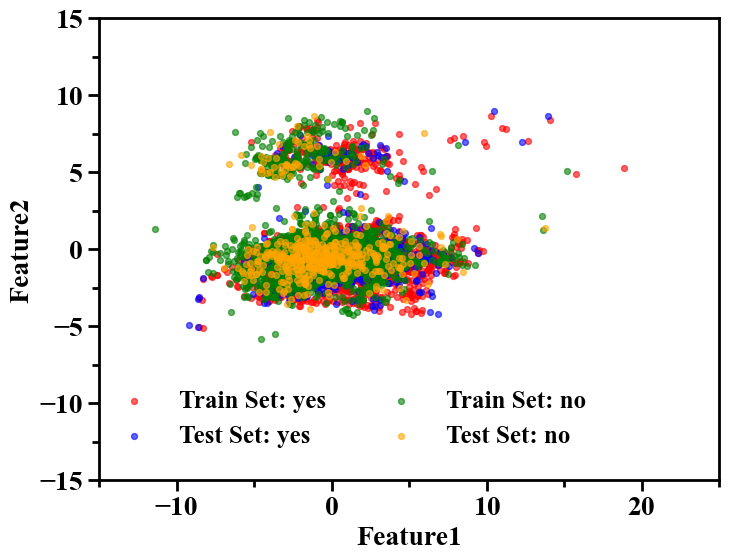

In [55]:
plt.rcParams["axes.labelweight"] ="bold"
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.weight"]="bold"
plt.rcParams["font.size"]=20
import matplotlib.ticker as ticker
# 创建你画布
fig,ax = plt.subplots(figsize=(8,6))
# 设置边框
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(
    which="major"
    , bottom = True
    , left = True
    , direction="out"
    , width=2
    , length=8
    , labelsize = 20
)
ax.tick_params(
    which="minor"
    , bottom = True
    , left = True
    , direction="out"
    , width=2
    , length=5
    , labelsize = 20
)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
X_pca = dfAfPCA["feature1"].to_list()
Y_pca = dfAfPCA["feature2"].to_list()

# 将dfAfPCA
train_yes_x = []
train_no_x = []
train_yes_y = []
train_no_y = []
var1 = y_train.to_list()
for i in range(len(var1)):
    if var1[i] == 1:
        train_yes_x.append(X_pca[i])
        train_yes_y.append(Y_pca[i])
    else:
        train_no_x.append(X_pca[i])
        train_no_y.append(Y_pca[i])
test_yes_x = []
test_no_x = []
test_yes_y = []
test_no_y = []
var2 = y_test.to_list()
for i in range(len(var2)):
    if var2[i] == 1:
        test_yes_x.append(X_pca[i+len(var1)])
        test_yes_y.append(Y_pca[i+len(var1)])
    else:
        test_no_x.append(X_pca[i+len(var1)])
        test_no_y.append(Y_pca[i+len(var1)])
plt.scatter(train_yes_x,train_yes_y,s=18,label="Train Set: yes",c = "red",alpha=0.6)
plt.scatter(test_yes_x,test_yes_y,s=18,label="Test Set: yes",c= "blue",alpha=0.6)

plt.scatter(train_no_x,train_no_y,s=18,label="Train Set: no",c="green",alpha=0.6)
plt.scatter(test_no_x,test_no_y,s=18,label="Test Set: no",c= "orange",alpha=0.6)
#plt.scatter(train_yes_x+test_yes_x,train_yes_y+test_yes_y,s=5,label="IC50 <= 5000nM",c="#C82423",alpha=1)
#plt.scatter(train_no_x+test_no_x,train_no_y+test_no_y,s=5,label="IC50 > 5000nM",c= "#2878B5",alpha=0.3)
ax.set_xlim([-15,25])
ax.set_ylim([-15,15])
#ax.set_xlim([-2,2])
#ax.set_ylim([-2,2])
ax.set_xlabel("Feature1")
ax.set_ylabel("Feature2")
lg1 = ax.legend(frameon=False,prop={"size":18}, ncol=2,loc=(0.0001,0.05))
for lg in lg1.get_lines():
    lg.set_markersize(20)
#plt.savefig("./YES-NO.jpg",dpi=300)
#plt.savefig("./Train-Test-scatter-NO.jpg",dpi=300)
plt.savefig("./Train-Test-scatter-YES.jpg",dpi=300)
plt.show()

In [12]:
# 储存上述画图数据
pd.DataFrame([train_yes_x,train_yes_y]).T.to_csv("./train_yes_xy.csv",index=None,header=None)
pd.DataFrame([train_no_x,train_no_y]).T.to_csv("./train_no_xy.csv",index=None,header=None)
pd.DataFrame([test_yes_x,test_yes_y]).T.to_csv("./test_yes_xy.csv",index=None,header=None)
pd.DataFrame([test_no_x,test_no_y]).T.to_csv("./test_no_xy.csv",index=None,header=None)

# 随机森林二分类模型

In [58]:
# 利用网格搜索优化参数

def ParmOPT_RF(X,Y):
    #X = DATA.iloc[:,3:]
    #Y = DATA["IC50"]
    # 20240328 数据预处理
    
    myPCA.fit_transform(StandardScaler().fit_transform(DFP))
    base_estimator = RandomForestClassifier(random_state=1)
    
    n_estimators = [50, 100, 150, 200, 250, 300, 400, 500]
    criterion = ["entropy","gini"]
    max_depth=[3,6,9,12,15,18,21]

    param_grid = {'n_estimators': n_estimators,"criterion":criterion,"max_depth":max_depth,}

    scores = ['precision', 'recall',"f1"]
    dic = {}
    for score in scores:
        print("# Tuning hyper-parameters for {}".format(score))
        print()
        classifier = GridSearchCV(base_estimator, 
                                  param_grid, cv=10, 
                                  scoring=score
                                  )
        classifier.fit(X,Y.ravel())
        print("Best parameters set found on development set:")
        print(classifier.best_params_)
        print("-"*10)
        print("Grid scores on development set:")
        means = classifier.cv_results_['mean_test_score']
        stds = classifier.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, classifier.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
            if score not in dic.keys():
                dic[score]=[]
                dic[score].append(mean)
            else:
                dic[score].append(mean)
    return dic

In [56]:
x_train

,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,...,MACCS142,MACCS143,MACCS144,MACCS146,MACCS148,MACCS149,MACCS150,MACCS158,MACCS161,MACCS167
1586,0.330660,-1.000000,1.000000,0.330660,79.905002,10.038619,-2.387852,2.292828,-2.997000,5.397268,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2712,0.059846,-0.393030,0.393030,0.059846,16.266235,10.093000,-2.268952,2.077406,-2.353745,4.889743,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1004,0.316600,-0.496758,0.496758,0.316600,16.465306,9.879833,-2.266687,2.250633,-2.434457,5.734741,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5221,0.416587,-0.493405,0.493405,0.416587,16.550333,10.062043,-2.171467,2.201289,-2.207819,5.858443,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4878,0.414454,-0.410216,0.414454,0.410216,16.553517,10.155997,-2.338118,2.147095,-2.473165,5.914462,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0.513084,-0.280824,0.513084,0.280824,31.220579,10.501997,-2.136426,2.513107,-2.042049,7.475898,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
5192,0.118265,-0.507676,0.507676,0.118265,16.255322,10.015007,-2.058844,2.218637,-1.863031,5.358349,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3980,0.160508,-0.492859,0.492859,0.160508,35.495773,9.856623,-2.330442,2.395441,-2.369811,6.309256,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
235,0.454362,-0.283965,0.454362,0.283965,28.331462,10.125749,-2.169992,2.207307,-2.379438,6.882764,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [59]:
optRF = ParmOPT_RF(x_train,y_train)

# Tuning hyper-parameters for precision

Best parameters set found on development set:
{'criterion': 'entropy', 'max_depth': 21, 'n_estimators': 400}
----------
Grid scores on development set:
0.697 (+/-0.024) for {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 50}
0.698 (+/-0.026) for {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 100}
0.698 (+/-0.025) for {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 150}
0.699 (+/-0.024) for {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 200}
0.699 (+/-0.026) for {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 250}
0.699 (+/-0.027) for {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 300}
0.700 (+/-0.027) for {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 400}
0.698 (+/-0.026) for {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 500}
0.771 (+/-0.044) for {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 50}
0.775 (+/-0.035) for {'criterion': 'entropy', 'max_depth': 6, 

## 公用代码块
- plot_confusion_matrix: 用于绘制混淆矩阵
- ROC: ROC-AUC曲线
- save_feature_sele: 保存模型的特征

In [24]:
# 混淆矩阵
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    config = {
    "font.size": 20, # medium/large/small
    'font.style':'normal', # normal/italic/oblique
    'font.weight':'bold', # bold
    "axes.unicode_minus": False,# 用来正常显示负号
    }
    plt.rcParams.update(config)
    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predict')
    plt.savefig('./confusion_matrix.png', dpi=300)
    plt.show()
    plt.rcParams.update(plt.rcParamsDefault)


from sklearn.metrics import roc_curve, auc, plot_roc_curve
# cutoff: 预测概率
def ROC(y_test,y_test_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure()

    # label 0
    fpr[0], tpr[0], _ = roc_curve(y_test, y_test_score[:, 0])
    roc_auc[0] = auc(fpr[0], tpr[0])

    # label 1
    fpr[1], tpr[1], _ = roc_curve(y_test, y_test_score[:, 1])
    roc_auc[1] = auc(fpr[1], tpr[1])

    lw = 2
    plt.plot(fpr[1], tpr[1], color='red', lw=lw, label='ROC curve (area = {:.4f})'.format(roc_auc[1]))
    plt.plot([0, 1], [0, 1], color='#00bc57', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for test set')
    plt.grid()
    plt.legend(loc="lower right")
    plt.savefig("./ROC.jpg", dpi=300)
    plt.show()
    return (fpr[1], tpr[1])

def save_feature_sele(lis,title):
    with open("./feature_sele_{}.txt".format(title),"w") as F:
        for i in lis:
            F.write(i + "\n")



              precision    recall  f1-score   support

           0       0.88      0.81      0.84       464
           1       0.87      0.92      0.89       644

    accuracy                           0.87      1108
   macro avg       0.87      0.86      0.87      1108
weighted avg       0.87      0.87      0.87      1108

Confusion matrix, without normalization
[[376  88]
 [ 53 591]]


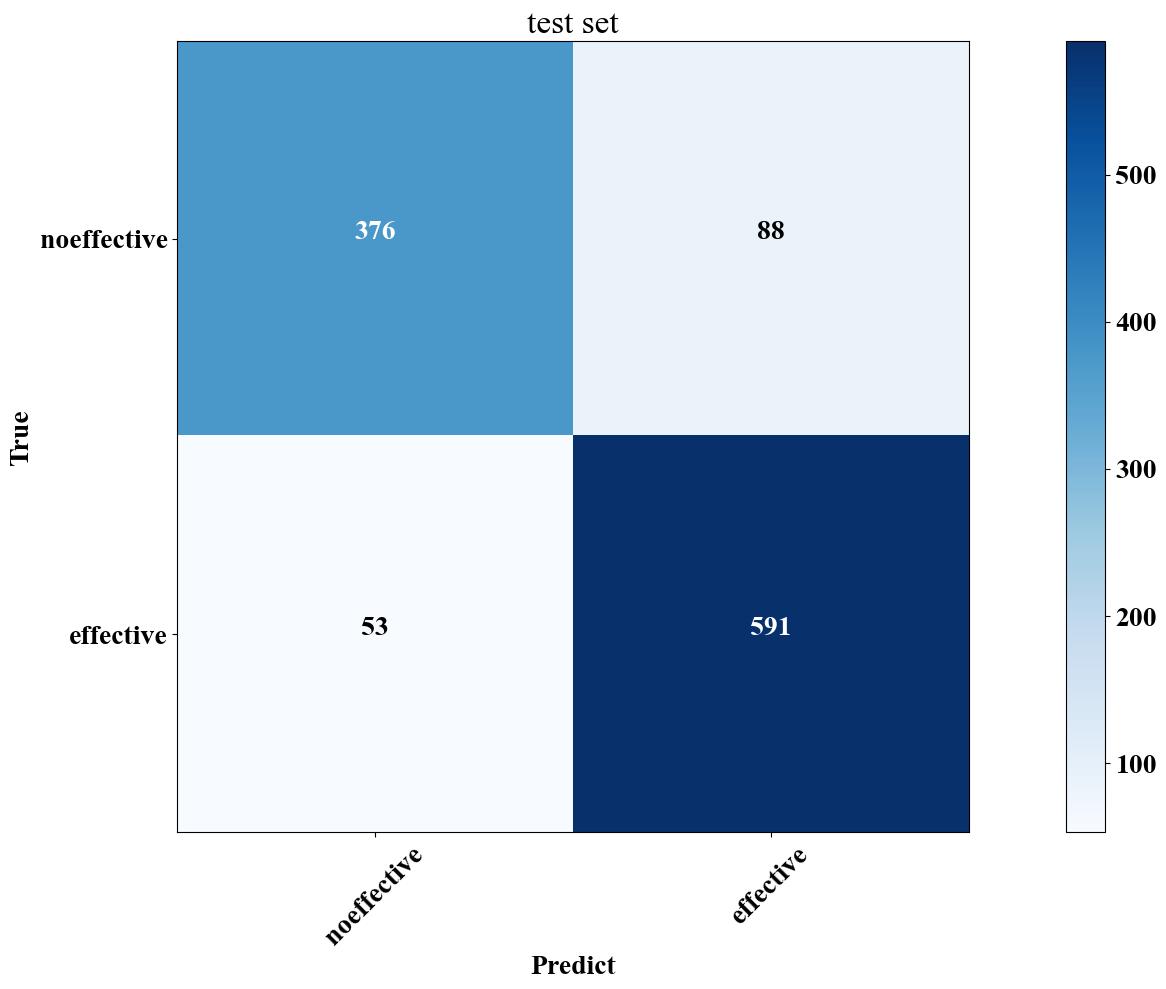

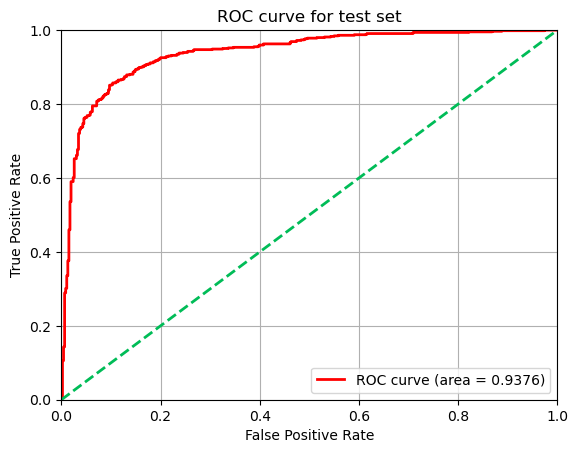

In [26]:
RF_classifier = RandomForestClassifier(
    n_estimators=500, 
    random_state=1,
    criterion = 'gini',
    max_depth = 18
    
)
RF_classifier.fit(x_train, y_train.ravel())

RF_y_test_pred = RF_classifier.predict(x_test)
print(classification_report(y_test, RF_y_test_pred))
# calculate the training set confusion matrix
RF_cnf_matrix = confusion_matrix(y_test, RF_y_test_pred)
np.set_printoptions(precision=2)
# without normalization confusion matrix
plot_confusion_matrix(RF_cnf_matrix, classes=['noeffective', 'effective'],title='test set')

RF_y_test_score = RF_classifier.predict_proba(x_test)
RF_ROC = ROC(y_test,RF_y_test_score)

# 保存RF的ROC曲线数值
pd.DataFrame(RF_ROC).T.to_csv("./RF/ROC.csv",index=None,header=None)


# 保存模型
import joblib
joblib.dump(RF_classifier,'./RF/MODEL_RF.pkl')
model1 = joblib.load(filename="./RF/MODEL_RF.pkl")

save_feature_sele(DATA.iloc[:,3:].columns.to_list(),"RF")

# XGboost

In [27]:
def ParmOPT_XGB(X,Y):
    #X = DATA.iloc[:,3:]
    #Y = DATA["IC50"]
    base_estimator = XGBClassifier(random_state=1)
    n_estimators  = [50,100,200, 250, 300, 400, 500]
    learning_rate = [0.01, 0.1, 0.5,1] 
    max_depth     = [ 5,10,15]
    booster = ["gbtree","gblinear","dart"]

    param_grid = {'n_estimators' : n_estimators,
                                'learning_rate': learning_rate,
                                'max_depth'    : max_depth,
 
                                }

    scores = ['precision', 'recall',"f1"]
    dic = {}
    for score in scores:
        print("# Tuning hyper-parameters for {}".format(score))
        print()
        classifier = GridSearchCV(base_estimator, 
                                  param_grid, cv=10, 
                                  scoring=score
                                  )
        classifier.fit(X,Y.ravel())
        print("Best parameters set found on development set:")
        print(classifier.best_params_)
        print("-"*10)
        print("Grid scores on development set:")
        means = classifier.cv_results_['mean_test_score']
        stds = classifier.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, classifier.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
            if score not in dic.keys():
                dic[score]=[]
                dic[score].append((mean,params))
            else:
                dic[score].append((mean,params))
        
    return dic

In [28]:
optXGB = ParmOPT_XGB(x_train,y_train)

# Tuning hyper-parameters for precision

Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
----------
Grid scores on development set:
0.748 (+/-0.033) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.769 (+/-0.037) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
0.800 (+/-0.038) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
0.807 (+/-0.039) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250}
0.815 (+/-0.037) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
0.824 (+/-0.038) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400}
0.831 (+/-0.038) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
0.808 (+/-0.052) for {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 50}
0.836 (+/-0.045) for {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}
0.853 (+/-0.028) for {'learning_rate': 0.01, 'max_depth': 10, 'n_estima

              precision    recall  f1-score   support

           0       0.86      0.81      0.84       464
           1       0.87      0.91      0.89       644

    accuracy                           0.87      1108
   macro avg       0.87      0.86      0.86      1108
weighted avg       0.87      0.87      0.87      1108

Confusion matrix, without normalization
[[377  87]
 [ 59 585]]


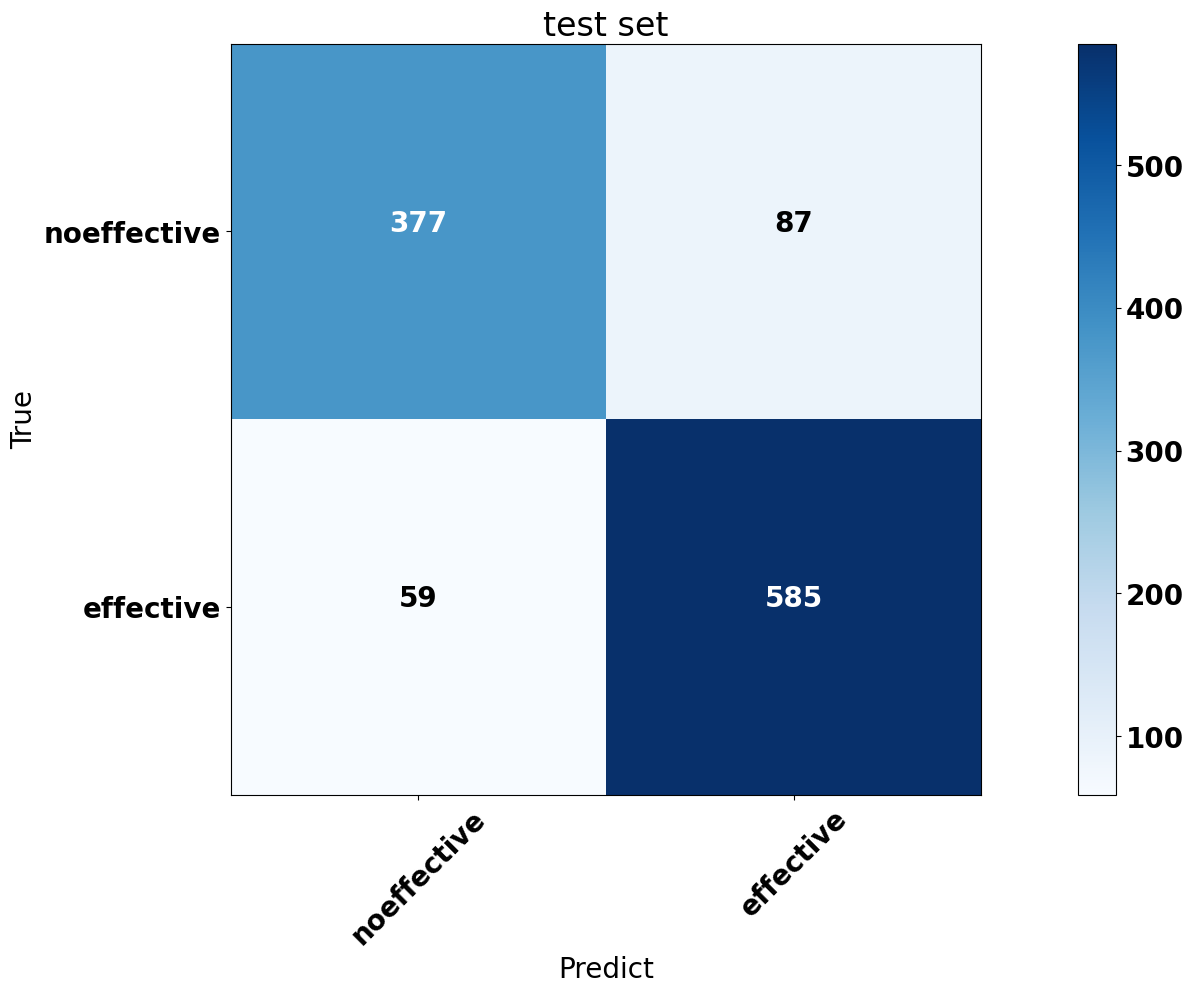

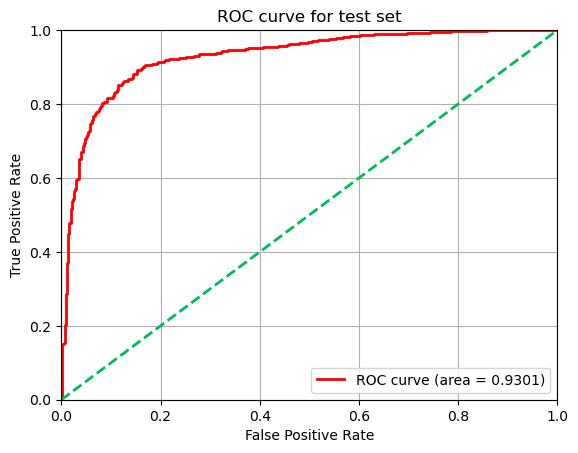

In [29]:
XG_classifier = XGBClassifier(
    random_state=1,
    learning_rate=0.1,
    max_depth=10,   
    n_estimators=200,         
    )

XG_classifier .fit(x_train, y_train.ravel())
XGB_y_test_pred = XG_classifier.predict(x_test)
print(classification_report(y_test, XGB_y_test_pred))

# calculate the training set confusion matrix
cnf_matrix = confusion_matrix(y_test,XGB_y_test_pred)
np.set_printoptions(precision=2)
# without normalization confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['noeffective', 'effective'],title='test set')
XGB_y_test_score = XG_classifier.predict_proba(x_test)
XGB_ROC = ROC(y_test,XGB_y_test_score)

# 保存RF的ROC曲线数值
pd.DataFrame(XGB_ROC).T.to_csv("./XGB/ROC.csv",index=None,header=None)

joblib.dump(XG_classifier,'./XGB/MODEL_XGB.pkl')
model2 = joblib.load(filename="./XGB/MODEL_XGB.pkl")

# ExtraTree

In [34]:
def ParmOPT_EXT(X,Y):
    #X = DATA.iloc[:,3:]
    #Y = DATA["IC50"]

    base_estimator = ExtraTreesClassifier(random_state=1)
    
    n_estimators = [10, 25, 50, 75, 100, 150, 200, 250, 300, 400, 500,600,700]
    max_depth = [1, 3, 5, 10, 20,25,30]
    #n_estimators = [1,2,3,4,5]
    param_grid = {'n_estimators': n_estimators,"max_depth":max_depth}
    scores = ['precision', 'recall',"f1"]
    dic = {}
    for score in scores:
        print("# Tuning hyper-parameters for {}".format(score))
        print()
        classifier = GridSearchCV(base_estimator, 
                                  param_grid, cv=10, 
                                  scoring=score
                                  )
        classifier.fit(X,Y.ravel())
        print("Best parameters set found on development set:")
        print(classifier.best_params_)
        print("-"*10)
        print("Grid scores on development set:")
        means = classifier.cv_results_['mean_test_score']
        stds = classifier.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, classifier.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
            if score not in dic.keys():
                dic[score]=[]
                dic[score].append(mean)
            else:
                dic[score].append(mean)
    return dic

In [35]:
optEXT = ParmOPT_EXT(x_train,y_train)

# Tuning hyper-parameters for precision

Best parameters set found on development set:
{'max_depth': 30, 'n_estimators': 500}
----------
Grid scores on development set:
0.592 (+/-0.010) for {'max_depth': 1, 'n_estimators': 10}
0.590 (+/-0.005) for {'max_depth': 1, 'n_estimators': 25}
0.592 (+/-0.006) for {'max_depth': 1, 'n_estimators': 50}
0.589 (+/-0.003) for {'max_depth': 1, 'n_estimators': 75}
0.587 (+/-0.003) for {'max_depth': 1, 'n_estimators': 100}
0.587 (+/-0.004) for {'max_depth': 1, 'n_estimators': 150}
0.587 (+/-0.003) for {'max_depth': 1, 'n_estimators': 200}
0.587 (+/-0.003) for {'max_depth': 1, 'n_estimators': 250}
0.587 (+/-0.004) for {'max_depth': 1, 'n_estimators': 300}
0.587 (+/-0.004) for {'max_depth': 1, 'n_estimators': 400}
0.588 (+/-0.004) for {'max_depth': 1, 'n_estimators': 500}
0.588 (+/-0.004) for {'max_depth': 1, 'n_estimators': 600}
0.588 (+/-0.004) for {'max_depth': 1, 'n_estimators': 700}
0.664 (+/-0.022) for {'max_depth': 3, 'n_estimators': 10}
0.669 (+/-

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       464
           1       0.89      0.92      0.90       644

    accuracy                           0.88      1108
   macro avg       0.88      0.88      0.88      1108
weighted avg       0.88      0.88      0.88      1108

Confusion matrix, without normalization
[[388  76]
 [ 53 591]]


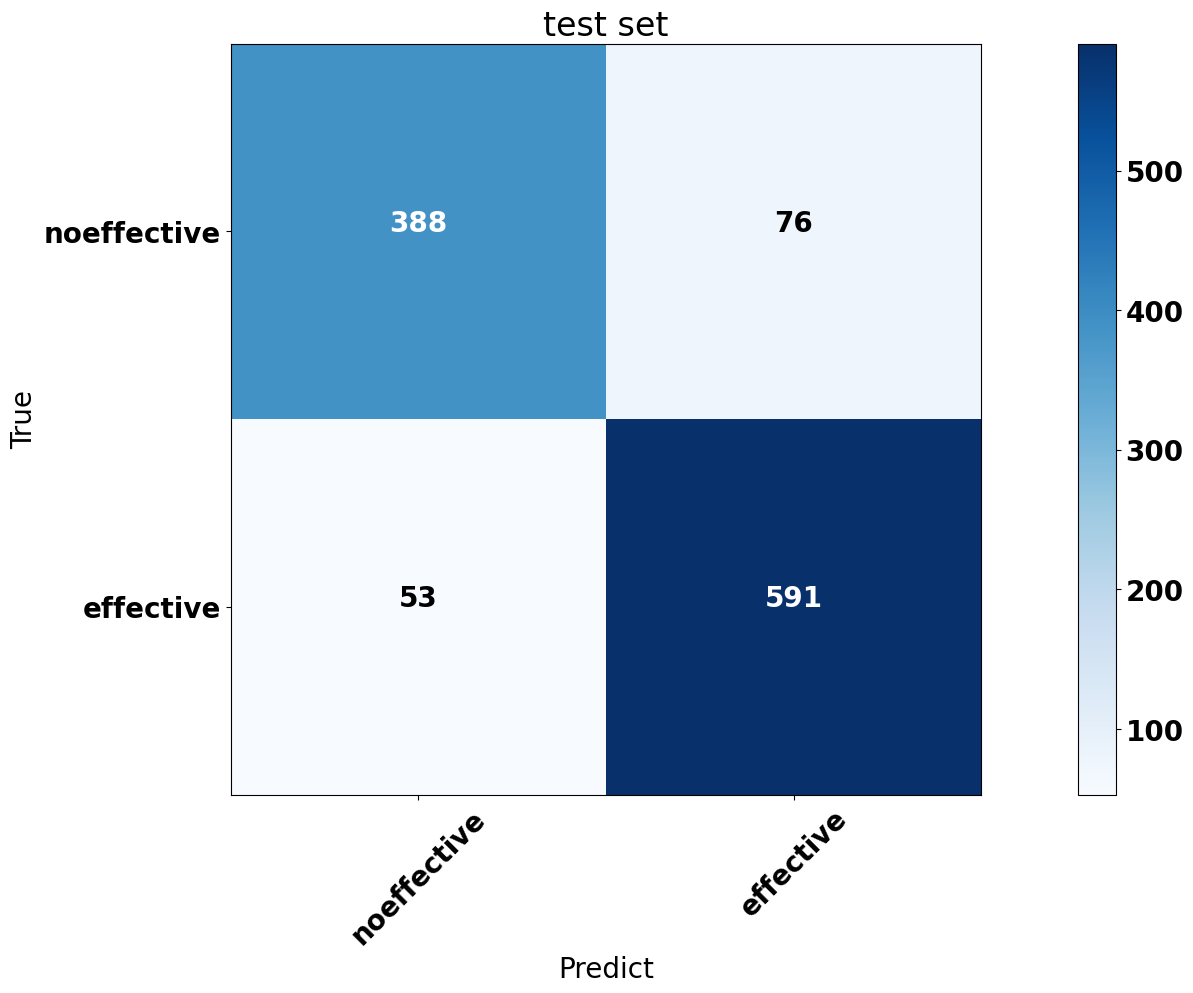

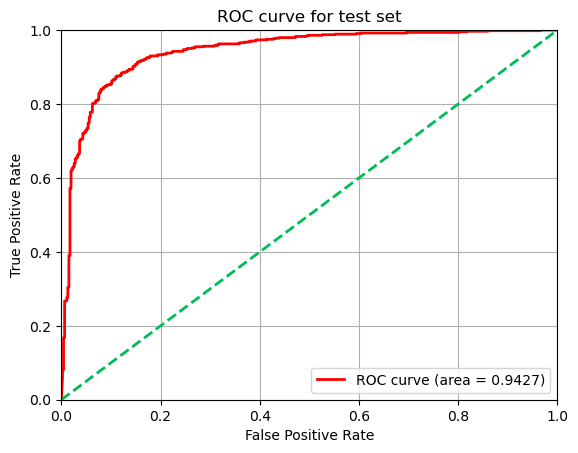

In [36]:
EXT_classifier = ExtraTreesClassifier(
    n_estimators=700, 
    max_depth = 30,
    random_state=1
)
EXT_classifier.fit(x_train, y_train.ravel())

EXT_y_test_pred = EXT_classifier.predict(x_test)
print(classification_report(y_test, EXT_y_test_pred))
# calculate the training set confusion matrix
cnf_matrix = confusion_matrix(y_test, EXT_y_test_pred)
np.set_printoptions(precision=2)
# without normalization confusion matrix

plot_confusion_matrix(cnf_matrix, classes=['noeffective', 'effective'],title='test set')
EXT_y_test_score = EXT_classifier.predict_proba(x_test)
EXT_ROC = ROC(y_test,EXT_y_test_score)
#y_test_score
# 保存RF的ROC曲线数值
pd.DataFrame(EXT_ROC).T.to_csv("./EXT/ROC.csv",index=None,header=None)

joblib.dump(EXT_classifier,'./EXT/MODEL_EXT.pkl')
model3 = joblib.load(filename="./EXT/MODEL_EXT.pkl")

# 利用三个模型进行投票法预测

In [37]:
#model1, model2, model3


def MLvote(M1,M2,M3,xData):
    y1 = M1.predict(xData)
    y2 = M3.predict(xData)
    y3 = M3.predict(xData)
    return (y1,y2,y3)

zjh = MLvote(model1, model2, model3,x_test)

In [38]:
final_out = []
r = [0.3,0.4,0.3]
for i in range(len(zjh[0])):
    sum1 = 0
    sum0 = 0
    for j in range(3):
        if zjh[j][i] == 1:
            sum1 += r[j]
        else:
            sum0 += r[j] 
    if sum1 >= sum0:
        # 这里可以加一个随机接受
        final_out.append(1)
    else:
        final_out.append(0)
final_out = np.array(final_out)

In [39]:
print(classification_report(y_test, final_out))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       464
           1       0.89      0.92      0.90       644

    accuracy                           0.88      1108
   macro avg       0.88      0.88      0.88      1108
weighted avg       0.88      0.88      0.88      1108



In [ ]:
pd.DataFrame([y_test.to_numpy().astype("int"),zjh[0],zjh[1],zjh[2],final_out]).T.to_csv("./11111.csv",index=None,header=None)